In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [2]:
SEED=101
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [4]:
def tokenize_de(text):
    
    return [t.text for t in spacy_de.tokenizer(text)]

def tokenize_en(text):
    
    return [t.text for t in spacy_en.tokenizer(text)]

In [5]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            include_lengths = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)


In [6]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

In [7]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)

In [35]:
class Encoder(nn.Module):
    def __init__(self,input_dim, hidden_dim,embed_dim,dropout):
        super().__init__()
        
        self.embedding=nn.Embedding(input_dim,embed_dim)
        self.rnn = nn.GRU(embed_dim,hidden_dim,bidirectional = True)
        self.fc = nn.Linear(hidden_dim*2,hidden_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self,src,src_len):
        
        embedded = self.embedding(src)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len)
        packed_outputs, hidden = self.rnn(packed_embedded)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        return hidden,outputs

In [36]:
hidden = torch.tensor([[1,2,4],[4,6,7]])
print(hidden.shape)
hidden = hidden.unsqueeze(0)
print(hidden.shape)
hidden.repeat([5,1,1]).shape

torch.Size([2, 3])
torch.Size([1, 2, 3])


torch.Size([5, 2, 3])

In [37]:
class attention(nn.Module):
    def __init__(self,hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim*3,hidden_dim)
        self.v = nn.Linear(hidden_dim,1, bias=False)
    
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        #print(hidden.shape)
        #print(encoder_outputs.shape)
        #print(torch.cat((hidden, encoder_outputs), dim = 2).shape)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention = [batch size, src len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

In [38]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, embedding_dim,attention,dropout):
        super().__init__()
        
        self.attention = attention
        self.embedding = nn.Embedding(output_dim,embedding_dim)
        self.rnn = nn.GRU(hidden_dim*2+embedding_dim,hidden_dim)
        self.fc = nn.Linear(hidden_dim*3+embedding_dim,output_dim)
        self.dropout = nn.Dropout(dropout)
        self.output_dim=output_dim
        
    def forward(self, input, hidden, encoder_outputs, mask):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)
        
        a = self.attention(hidden, encoder_outputs, mask)
        
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        output,hidden = self.rnn(rnn_input,hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc(torch.cat((output, weighted, embedded), dim = 1))
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [39]:
class seq2seq(nn.Module):
    def __init__(self,encoder,decoder,src_padding_idx,device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.src_padding_idx=src_padding_idx
    
    def create_mask(self, src):
        mask = (src != self.src_padding_idx).permute(1, 0)
        return mask
    
    def forward(self,src,src_len, trg,teacher_forcing_ratio = 0.5):
        trg_len = trg.shape[0]
        batch_size = src.shape[1]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(trg_len,batch_size,trg_vocab_size).to(self.device)
        
        hidden,enc_output = self.encoder(src,src_len)
        
        input = trg[0,:]
        mask = self.create_mask(src)
        for t in range(1, trg_len):
            output, hidden,_ = self.decoder(input,hidden,enc_output,mask)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1) 
            input = trg[t] if teacher_force else top1
        return outputs

In [15]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 128
HID_DIM = 256
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = attention(HID_DIM)
enc = Encoder(INPUT_DIM, HID_DIM, EMB_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, HID_DIM, EMB_DIM, attn,DEC_DROPOUT)

model = seq2seq(enc, dec, SRC_PAD_IDX, device).to(device)

In [16]:

def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

seq2seq(
  (encoder): Encoder(
    (embedding): Embedding(7854, 128)
    (rnn): GRU(128, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.5)
  )
  (decoder): Decoder(
    (attention): attention(
      (attn): Linear(in_features=768, out_features=256, bias=True)
      (v): Linear(in_features=256, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 128)
    (rnn): GRU(640, 256)
    (fc): Linear(in_features=896, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5)
  )
)

In [17]:
optimizer = optim.Adam(model.parameters())
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [18]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [22]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [23]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [24]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 4m 50s
	Train Loss: 3.952 | Train PPL:  52.058
	 Val. Loss: 3.575 |  Val. PPL:  35.708
Epoch: 02 | Time: 3m 35s
	Train Loss: 3.304 | Train PPL:  27.224
	 Val. Loss: 2.926 |  Val. PPL:  18.655
Epoch: 03 | Time: 3m 51s
	Train Loss: 2.815 | Train PPL:  16.687
	 Val. Loss: 2.669 |  Val. PPL:  14.425
Epoch: 04 | Time: 3m 54s
	Train Loss: 2.447 | Train PPL:  11.556
	 Val. Loss: 2.548 |  Val. PPL:  12.782
Epoch: 05 | Time: 4m 17s
	Train Loss: 2.174 | Train PPL:   8.796
	 Val. Loss: 2.410 |  Val. PPL:  11.129
Epoch: 06 | Time: 3m 54s
	Train Loss: 1.948 | Train PPL:   7.015
	 Val. Loss: 2.345 |  Val. PPL:  10.430
Epoch: 07 | Time: 7m 20s
	Train Loss: 1.779 | Train PPL:   5.922
	 Val. Loss: 2.386 |  Val. PPL:  10.871
Epoch: 08 | Time: 5m 44s
	Train Loss: 1.614 | Train PPL:   5.024
	 Val. Loss: 2.411 |  Val. PPL:  11.140
Epoch: 09 | Time: 6m 19s
	Train Loss: 1.466 | Train PPL:   4.333
	 Val. Loss: 2.436 |  Val. PPL:  11.428
Epoch: 10 | Time: 6m 44s
	Train Loss: 1.343 | Train PPL

In [73]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    
    with torch.no_grad():
        hidden,encoder_outputs = model.encoder(src_tensor, src_len)
    
    
        
    #hidden=hidden.squeeze(1)
    mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [74]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [75]:
example_idx = 12

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'schwarzer', 'hund', 'und', 'ein', 'gefleckter', 'hund', 'kämpfen', '.']
trg = ['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting']


In [76]:
#hidden = [batch size, dec hid dim]
#encoder_outputs = [src len, batch size, enc hid dim * 2]
    
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'fighting', '.', '<eos>']


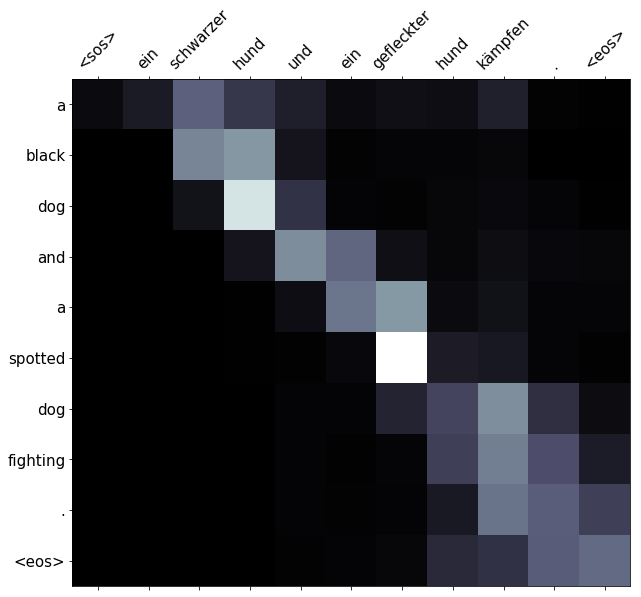

In [77]:
display_attention(src, translation, attention)